In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress
from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
from scipy.stats import ks_2samp

In [2]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly/'
files = np.sort(glob.glob(f'{path_anoms}*'))
names_exp = np.array([files[id_exp].split('_')[-1][:-7] for id_exp in range(len(files))])

In [3]:
import pandas as pd
import xarray as xr

# Create a dictionary to store data for all experiments
data_dict = {}

# Read data for all experiments and store them in the dictionary
for id_exp, exp_name in enumerate(names_exp):
    # Read the labels dataframe
    labels_df = pd.read_csv(f'../Data/LENS2/Labels/df_labels_{exp_name}.csv',
                            index_col=0, parse_dates=True, names=['WR'], skiprows=1)
    
    # Read the distances dataframe
    distances_df = pd.read_csv(f'../Data/LENS2/Distances/df_labels_{exp_name}.csv',
                               index_col=0, parse_dates=True, names=['distance'], skiprows=1)
    
    # Read the composites/averages xarray DataArray
    composites_da = xr.open_dataset(f'../Data/LENS2/avgs/avgs_{exp_name}.nc').Z_anoms
    
    # Store the read data in the dictionary under the experiment name
    data_dict[exp_name] = {'labels': labels_df, 'distances': distances_df, 'composites': composites_da}


In [4]:
# Define a function to convert a date into a season
def get_season(date):
    """Map a date to its corresponding season."""
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Loop through each experiment in the data dictionary
for exp_name, data in data_dict.items():
    # Assuming data['labels'] is a DataFrame with a 'time' column of datetime type
    # if 'time' in data['labels'].columns:
    # Add a new column 'season' to the labels DataFrame based on the 'time' column
    data['labels']['season'] = data['labels'].index.map(get_season)
    data['distances']['season'] = data['labels'].index.map(get_season)
    # else:
    #     print(f"Experiment {exp_name} does not have a 'time' column in its labels DataFrame.")

In [5]:
names = ["Greeland High","Pacific Trough","West Coast High","Pacific High","Alaskan Ridge", "Atlantic Low","No WR"]

In [6]:
def get_events(df_labels):
    # Step 1: Identify changes in class to find the start of each event
    df_labels['shifted'] = df_labels['WR'].shift(1)
    df_labels['start'] = df_labels['WR'] != df_labels['shifted']
    df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
    df_labels['start_date'].fillna(method='ffill', inplace=True)
    
    # Step 2: Calculate the duration of each event
    # Convert the Timedelta to its 'days' component
    df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1
    
    # Step 3: Create the df_events DataFrame
    # Group by 'start_date' and 'class' to get the duration of each class event
    df_events = df_labels.groupby(['start_date', 'WR']).agg({'duration': 'max'}).reset_index()
    
    # Drop the temporary columns used for calculations
    df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)
    
    # Set 'start_date' as the index if needed
    df_events.set_index('start_date', inplace=True)
    
    return df_events

In [7]:
for exp_name in names_exp:
    data_dict[exp_name]['events'] = get_events(data_dict[exp_name]['labels'])
    
for exp_name, data in data_dict.items():
    # Assuming data['labels'] is a DataFrame with a 'time' column of datetime type
    # if 'time' in data['labels'].columns:
    # Add a new column 'season' to the labels DataFrame based on the 'time' column
    data['events']['season'] = data['events'].index.map(get_season)

# Plots

In [8]:
names_wrs = ["Greenland High", "Pacific Trough", "West Coast High", 
                 "Pacific High", "Alaskan Ridge", "Atlantic Low", "No WR"]

seasons = ['Winter','Spring','Summer','Fall','All year']

In [9]:
path_stats_data = "../Data/LENS2_Historic_StatsZ500_MultiMember/"

In [10]:
dic_statistics = {}

for wr in range(len(names_wrs)):
    # print(wr)
    dic_statistics[wr] = {}
    for season in seasons:
        dic_statistics[wr][season] = np.load(f"{path_stats_data}dic_stats_z500_{wr}_{season.replace(' ','_')}.npy",
                             allow_pickle = True)[()]

In [83]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

def plot_composites(Composites, lon, lat, quantity_name, vmin, vmax, units, colormap, \
                    pathsave=None, multiply=1, p_values=None, p_threshold=0.05):
    """
    Plots composite maps with optional hatching for significance.

    Parameters:
    -----------
    Composites: dict
        Dictionary of composites for different weather regimes and seasons.
    lon, lat: ndarray
        Longitudes and latitudes of the data grid.
    quantity_name: str
        Name of the quantity to plot.
    vmin, vmax: float
        Minimum and maximum values for the colormap.
    units: str
        Units of the plotted quantity (for the colorbar).
    colormap: str
        Name of the colormap to use.
    pathsave: str, optional
        Path to save the figure. If None, the figure is displayed.
    multiply: float, optional
        Factor to multiply the data by before plotting.
    p_values: dict, optional
        Dictionary of p-values for each weather regime and season. Same structure as `Composites`.
    p_threshold: float, optional
        Threshold for significance (default is 0.05).
    """
    # Define the color levels and color map
    levels = np.linspace(vmin, vmax, 11)
    cmap = plt.get_cmap(colormap)

    # Create the figure and axes
    fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(15, 15), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
    axes = axes.flatten()

    names_wrs = ["Greenland High", "Pacific Trough", "West Coast High", 
                 "Pacific High", "Alaskan Ridge", "Atlantic Low", "No WR"]
    season_titles = ['Winter', 'Spring', 'Summer', 'Fall', 'All year']
    # lon = (lon + 180) % 360 - 180
    # Iterate over each weather regime (rows)
    for wr in range(7):
        # Iterate over each season (columns)
        for iseason, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall', 'All year']):
            ax = axes[wr * 5 + iseason]

            # Plot the composite map
            try:
                composite = Composites[str(wr)][season][quantity_name]
            except:
                composite = Composites[wr][season][quantity_name]

            # Convert longitudes to -180 to 180 range
            
            ax.set_extent([-80, 50, 20, 90], crs=ccrs.PlateCarree(central_longitude=-100))

            # Plot the composite values using pcolormesh
            cf = ax.pcolormesh(lon, lat, composite * multiply, vmin=vmin, vmax=vmax, 
                               cmap=cmap, transform=ccrs.PlateCarree())

            # # Add hatching based on p-values if provided
            # if p_values is not None:
            #     try:
            #         p_values_current = Composites[str(wr)][season][p_values]
            #     except:
            #         p_values_current = Composites[wr][season][p_values]

            #     # Create a mask where p-values are less than the threshold
            #     significance_mask = np.ma.masked_where(p_values_current < p_threshold, composite)

            #     # Overlay hatching on significant areas
            #     # ax.contourf(lon, lat, significance_mask, levels=[vmin, vmax], 
            #     #             colors='none', hatches=['/////'], transform=ccrs.PlateCarree())
            #     ax.pcolormesh(lon, lat, significance_mask,cmap='Greys', 
            #                   transform=ccrs.PlateCarree(),alpha=0.5)
            # Add hatching based on p-values if provided
            if p_values is not None:
                try:
                    p_values_current = Composites[str(wr)][season][p_values]
                except:
                    p_values_current = Composites[wr][season][p_values]
    
                # Create a mask where p-values are less than the threshold
                significance_mask = (p_values_current <= p_threshold)
    
                # Overlay hatching on significant areas
                hatch_plot = ax.contourf(lon, lat, significance_mask, levels=[0.5, 1.5], 
                            colors='none', hatches=['...'], transform=ccrs.PlateCarree())
                # Customize hatch properties if needed
                for collection in hatch_plot.collections:
                    collection.set_edgecolor('white')  # Change hatch color
                    collection.set_linewidth(0.)     # Change hatch line width
            # ax.contourf(lon, lat, significance_mask, levels=[0.5, 1], 
            #             colors='none', hatches=['xxx'], transform=ccrs.PlateCarree())

            # Add coastlines and gridlines
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, alpha=0.7)

            # Ensure y-ticks are present for the first column
            if iseason == 0:
                ax.set_yticks([])  # Example y-ticks, adjust as needed
                ax.set_ylabel(f'{names_wrs[wr]}', fontsize=13)
            else:
                ax.set_yticklabels([])  # Remove y-tick labels for other columns

            # Set the title for each season column (first row only)
            if wr == 0:
                ax.set_title(season_titles[iseason], fontsize=13)

            # Set font sizes for axes labels
            ax.tick_params(axis='both', which='major', labelsize=10)

    # Add a main title to the entire plot
    fig.suptitle(f"{quantity_name} - Composites", fontsize=18, y=0.96, 
                 horizontalalignment='left', x=0.)

    # Adjust layout to prevent overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Create colorbar
    cbar_ax = fig.add_axes([0.8, 0.95, 0.2, 0.01])  # Position similar to the legend
    cbar = fig.colorbar(cf, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(units, fontsize=13)
    cbar.ax.tick_params(labelsize=10)

    # Save or show the plot
    if pathsave:
        plt.savefig(pathsave, bbox_inches='tight')
        plt.close('all')
    else:
        plt.show()
        plt.close('all')

In [12]:
anoms = xr.open_dataset(files[0])
lat = anoms.lat
lon = anoms.lon

In [85]:
plot_composites(dic_statistics,lon,lat,\
                'trend',-0.025,0.025,\
                r'$\sigma/decade$','seismic',multiply=10, \
                p_values='trend_p_value',
                pathsave = f'../Figures/LENS2_z500_trend.png')

In [24]:
plot_composites(dic_statistics,lon,lat,\
                'diff_means',-0.1,0.1,\
                r'$\sigma$','seismic',multiply=1, \
                p_values='p_value_bootstrap',
                pathsave = f'../Figures/LENS2_z500_diff_means.png')

In [27]:
plot_composites(dic_statistics,lon,lat,\
                'meanfirst',-1,1,\
                r'$\sigma$','RdYlBu_r',multiply=1, \
                pathsave = f'../Figures/LENS2_z500_earlycomposites.png')

In [28]:
plot_composites(dic_statistics,lon,lat,\
                'meanlast',-1,1,\
                r'$\sigma$','RdYlBu_r',multiply=1, \
                pathsave = f'../Figures/LENS2_z500_latecomposites.png')

In [35]:
pvalues_temp = copy.deepcopy(dic_statistics[1]['Summer']['trend_p_value'])
trend_temp = copy.deepcopy(dic_statistics[1]['Summer']['trend'])

In [50]:
lon_temp = (lon + 180) % 360 - 180

In [74]:
200-360

-160

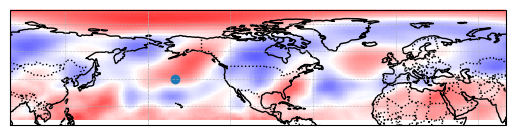

In [79]:
ax.set_extent([-80, 50, 20, 90], crs=ccrs.PlateCarree(central_longitude=-100))


fig, ax = plt.subplots(nrows=1, ncols=1,subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
significance_mask = (pvalues_temp <= 0.05)
ax.pcolormesh(lon,lat,trend_temp*10,vmin=-0.03,vmax=0.03,cmap='seismic', transform=ccrs.PlateCarree())
# ax.contourf(lon_temp, lat, significance_mask, levels=[0.5, 1.5], 
#                         colors='none', hatches=['...'], transform=ccrs.PlateCarree())
ax.scatter(-160,40,transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=False, linestyle='--', linewidth=0.5, alpha=0.7)

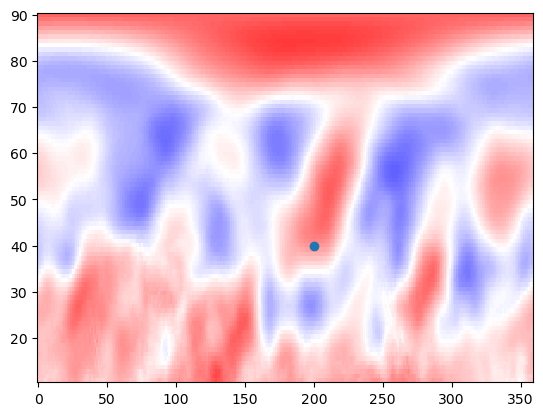

In [65]:

plt.pcolormesh(lon,lat,trend_temp*10,vmin=-0.03,vmax=0.03,cmap='seismic')
plt.scatter(200,40)

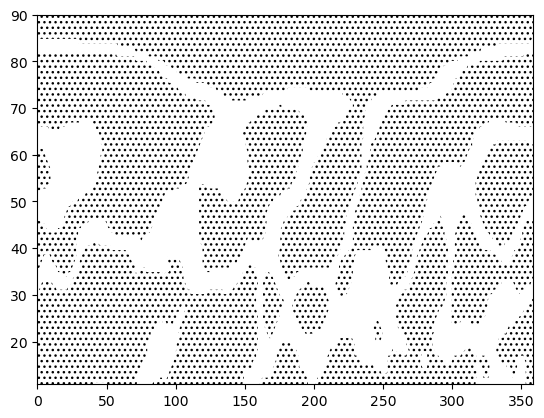

In [63]:
wr = 0
season = 'Spring'
dic_statistics_temp = np.load(f"{path_save_data}dic_stats_z500_{wr}_{season.replace(' ','_')}.npy",
                             allow_pickle = True)[()]

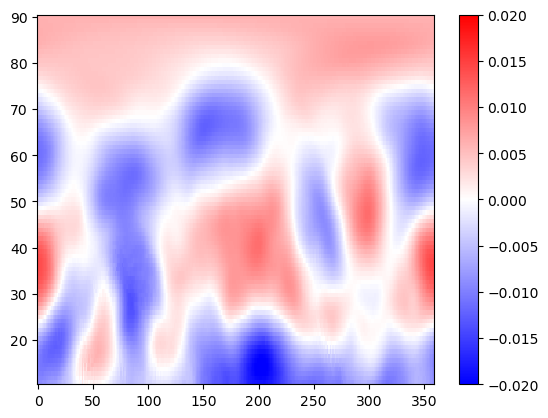

In [65]:
plt.pcolormesh(anoms.lon,anoms.lat,dic_statistics_temp['trend']*10,vmin=-0.02,vmax=0.02,cmap='bwr')
plt.colorbar()

In [53]:
180-360

-180

In [54]:
-120+360

240

In [24]:
def get_average_across_members(dic_full, name_var):
    l
    for exp_name in dic_full.keys():
        

['LE2-1011.001',
 'LE2-1031.002',
 'LE2-1051.003',
 'LE2-1071.004',
 'LE2-1091.005',
 'LE2-1111.006',
 'LE2-1131.007',
 'LE2-1151.008',
 'LE2-1171.009',
 'LE2-1191.010']